In [1]:
import cv2

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torch.nn import functional as F
from torch.utils.data._utils.collate import default_collate

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Directory paths
VIDEO_DIR = "/kaggle/input/ucf11-action-recognize/UCF11_updated_mpg"
OUTPUT_DIR = "/kaggle/working/temp_folder"

# Data Preprocessing

In [3]:
categories = os.listdir(VIDEO_DIR)
categories

['biking',
 'trampoline_jumping',
 'swing',
 'walking',
 'golf_swing',
 'soccer_juggling',
 'tennis_swing',
 'volleyball_spiking',
 'basketball',
 'horse_riding',
 'diving']

In [4]:
num_classes = len(categories)
num_classes

11

In [5]:
def create_dataset(input_folder):
    groups = []
    classes = os.listdir(input_folder)
    index = 0
    for class_name in sorted(classes):
        print(f'Extracting Data of Class: {class_name}')
        
        label_folder_path = os.path.join(input_folder, class_name)
        if os.path.isdir(label_folder_path):
            group_folders = os.listdir(label_folder_path)
            for group_folder in group_folders:
                if group_folder != 'Annotation':
                    video_dir = os.path.join(label_folder_path,group_folder)
                    for video_file in os.listdir(video_dir):
                        groups.append([os.path.join(video_dir, video_file), class_name])
            index += 1
    return groups

In [6]:
groups = create_dataset(VIDEO_DIR)

Extracting Data of Class: basketball
Extracting Data of Class: biking
Extracting Data of Class: diving
Extracting Data of Class: golf_swing
Extracting Data of Class: horse_riding
Extracting Data of Class: soccer_juggling
Extracting Data of Class: swing
Extracting Data of Class: tennis_swing
Extracting Data of Class: trampoline_jumping
Extracting Data of Class: volleyball_spiking
Extracting Data of Class: walking


In [7]:
groups[:5]

[['/kaggle/input/ucf11-action-recognize/UCF11_updated_mpg/basketball/v_shooting_05/v_shooting_05_01.mpg',
  'basketball'],
 ['/kaggle/input/ucf11-action-recognize/UCF11_updated_mpg/basketball/v_shooting_05/v_shooting_05_04.mpg',
  'basketball'],
 ['/kaggle/input/ucf11-action-recognize/UCF11_updated_mpg/basketball/v_shooting_05/v_shooting_05_03.mpg',
  'basketball'],
 ['/kaggle/input/ucf11-action-recognize/UCF11_updated_mpg/basketball/v_shooting_05/v_shooting_05_02.mpg',
  'basketball'],
 ['/kaggle/input/ucf11-action-recognize/UCF11_updated_mpg/basketball/v_shooting_09/v_shooting_09_05.mpg',
  'basketball']]

In [8]:
len(groups)

1600

In [9]:
# Convert to DataFrame
df = pd.DataFrame(groups, columns=["videos", "Category"])

# Display the DataFrame
df

,videos,Category
0,/kaggle/input/ucf11-action-recognize/UCF11_upd...,basketball
1,/kaggle/input/ucf11-action-recognize/UCF11_upd...,basketball
2,/kaggle/input/ucf11-action-recognize/UCF11_upd...,basketball
3,/kaggle/input/ucf11-action-recognize/UCF11_upd...,basketball
4,/kaggle/input/ucf11-action-recognize/UCF11_upd...,basketball
...,...,...
1595,/kaggle/input/ucf11-action-recognize/UCF11_upd...,walking
1596,/kaggle/input/ucf11-action-recognize/UCF11_upd...,walking
1597,/kaggle/input/ucf11-action-recognize/UCF11_upd...,walking
1598,/kaggle/input/ucf11-action-recognize/UCF11_upd...,walking


In [10]:
# Map category names to numeric labels
class_mapping = {category: idx for idx, category in enumerate(categories)}

print("Category to Label Mapping:")
class_mapping

Category to Label Mapping:


{'biking': 0,
 'trampoline_jumping': 1,
 'swing': 2,
 'walking': 3,
 'golf_swing': 4,
 'soccer_juggling': 5,
 'tennis_swing': 6,
 'volleyball_spiking': 7,
 'basketball': 8,
 'horse_riding': 9,
 'diving': 10}

### Label Encoding

In [11]:
df['label'] = df['Category'].map(class_mapping)
df

,videos,Category,label
0,/kaggle/input/ucf11-action-recognize/UCF11_upd...,basketball,8
1,/kaggle/input/ucf11-action-recognize/UCF11_upd...,basketball,8
2,/kaggle/input/ucf11-action-recognize/UCF11_upd...,basketball,8
3,/kaggle/input/ucf11-action-recognize/UCF11_upd...,basketball,8
4,/kaggle/input/ucf11-action-recognize/UCF11_upd...,basketball,8
...,...,...,...
1595,/kaggle/input/ucf11-action-recognize/UCF11_upd...,walking,3
1596,/kaggle/input/ucf11-action-recognize/UCF11_upd...,walking,3
1597,/kaggle/input/ucf11-action-recognize/UCF11_upd...,walking,3
1598,/kaggle/input/ucf11-action-recognize/UCF11_upd...,walking,3


### One-hot Encoding

In [12]:
# One-hot encode categories
def one_hot_encode(label, num_classes):
    one_hot = [0] * num_classes
    one_hot[int(label)] = 1
    return one_hot

# Add one-hot encoding column
df["one_hot"] = df["label"].apply(lambda x: one_hot_encode(x, num_classes))
df

,videos,Category,label,one_hot
0,/kaggle/input/ucf11-action-recognize/UCF11_upd...,basketball,8,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
1,/kaggle/input/ucf11-action-recognize/UCF11_upd...,basketball,8,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
2,/kaggle/input/ucf11-action-recognize/UCF11_upd...,basketball,8,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
3,/kaggle/input/ucf11-action-recognize/UCF11_upd...,basketball,8,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
4,/kaggle/input/ucf11-action-recognize/UCF11_upd...,basketball,8,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
...,...,...,...,...
1595,/kaggle/input/ucf11-action-recognize/UCF11_upd...,walking,3,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
1596,/kaggle/input/ucf11-action-recognize/UCF11_upd...,walking,3,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
1597,/kaggle/input/ucf11-action-recognize/UCF11_upd...,walking,3,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
1598,/kaggle/input/ucf11-action-recognize/UCF11_upd...,walking,3,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"


# Train, Test and Validation Split

In [13]:
# Splitting the DataFrame
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

In [14]:
train_df

,videos,Category,label,one_hot
542,/kaggle/input/ucf11-action-recognize/UCF11_upd...,golf_swing,4,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
102,/kaggle/input/ucf11-action-recognize/UCF11_upd...,basketball,8,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
637,/kaggle/input/ucf11-action-recognize/UCF11_upd...,horse_riding,9,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
238,/kaggle/input/ucf11-action-recognize/UCF11_upd...,biking,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1338,/kaggle/input/ucf11-action-recognize/UCF11_upd...,trampoline_jumping,1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...
463,/kaggle/input/ucf11-action-recognize/UCF11_upd...,golf_swing,4,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
632,/kaggle/input/ucf11-action-recognize/UCF11_upd...,horse_riding,9,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
1038,/kaggle/input/ucf11-action-recognize/UCF11_upd...,swing,2,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
1081,/kaggle/input/ucf11-action-recognize/UCF11_upd...,tennis_swing,6,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"


In [15]:
test_df

,videos,Category,label,one_hot
526,/kaggle/input/ucf11-action-recognize/UCF11_upd...,golf_swing,4,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
354,/kaggle/input/ucf11-action-recognize/UCF11_upd...,diving,10,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
168,/kaggle/input/ucf11-action-recognize/UCF11_upd...,biking,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
135,/kaggle/input/ucf11-action-recognize/UCF11_upd...,basketball,8,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
937,/kaggle/input/ucf11-action-recognize/UCF11_upd...,soccer_juggling,5,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
...,...,...,...,...
1074,/kaggle/input/ucf11-action-recognize/UCF11_upd...,swing,2,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
1315,/kaggle/input/ucf11-action-recognize/UCF11_upd...,trampoline_jumping,1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
383,/kaggle/input/ucf11-action-recognize/UCF11_upd...,diving,10,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
1273,/kaggle/input/ucf11-action-recognize/UCF11_upd...,trampoline_jumping,1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [16]:
val_df

,videos,Category,label,one_hot
975,/kaggle/input/ucf11-action-recognize/UCF11_upd...,swing,2,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
933,/kaggle/input/ucf11-action-recognize/UCF11_upd...,soccer_juggling,5,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
833,/kaggle/input/ucf11-action-recognize/UCF11_upd...,soccer_juggling,5,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
1443,/kaggle/input/ucf11-action-recognize/UCF11_upd...,volleyball_spiking,7,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
890,/kaggle/input/ucf11-action-recognize/UCF11_upd...,soccer_juggling,5,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
...,...,...,...,...
1564,/kaggle/input/ucf11-action-recognize/UCF11_upd...,walking,3,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
1268,/kaggle/input/ucf11-action-recognize/UCF11_upd...,trampoline_jumping,1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1097,/kaggle/input/ucf11-action-recognize/UCF11_upd...,tennis_swing,6,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
703,/kaggle/input/ucf11-action-recognize/UCF11_upd...,horse_riding,9,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"


# Video Preprocessing

### Extracting RGB Frames and Optical Flow

In [17]:
def extract_frames(video_path, frame_folder, SEQUENCE_LENGTH = 10):
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(frame_count / SEQUENCE_LENGTH), 1)
    frames = []
    
    for i in range(SEQUENCE_LENGTH):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * skip_frames_window)
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
        cv2.imwrite(f"{frame_folder}/frame_{i}.jpg", frame)
    
    cap.release()

    if not frames:
        raise ValueError(f"No frames found in video: {video_path}")
         
    return frames

In [18]:
def calculate_optical_flow(frames):
    if len(frames) < 2:
        raise ValueError("Insufficient frames for optical flow calculation.")
        
    flow_frames = []
    prev_frame = cv2.cvtColor(frames[0], cv2.COLOR_BGR2GRAY)
    
    for i in range(1, len(frames)):
        next_frame = cv2.cvtColor(frames[i], cv2.COLOR_BGR2GRAY)
        flow = cv2.calcOpticalFlowFarneback(prev_frame, next_frame, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        flow_frames.append(flow)
        prev_frame = next_frame
    
    return flow_frames

# Dataset Preparation

### Define a custom dataset class that loads RGB frames, optical flow, and labels.

In [19]:
class VideoDataset(Dataset):
    def __init__(self, dataframe, transform=False, rgb_transform=None, flow_transform=None):
        """
        Args:
            dataframe (pd.DataFrame): DataFrame containing video paths and labels.
            transform (callable, optional): Optional transform to be applied on frames.
        """
        self.dataframe = dataframe
        self.transform = transform
        self.rgb_transform = rgb_transform
        self.flow_transform = flow_transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        video_path = self.dataframe.iloc[idx]['videos']
        label_list = self.dataframe.iloc[idx]['one_hot']

        try:
            # Extract RGB frames and optical flow
            parts = video_path.split("/")
            video_name = parts[-1].split('.')[0]
            frame_folder = f"frames/{video_name}"  # Temporary folder to store frames
            os.makedirs(frame_folder, exist_ok=True)
    
            rgb_frames = extract_frames(video_path, frame_folder)
            if len(rgb_frames) < 10:
                # print(f"Skipping video {video_path} due to insufficient frames.")
                return None
            
            flow_frames = calculate_optical_flow(rgb_frames)
            if len(flow_frames) < 1:
                # print(f"Skipping video {video_path} due to no optical flow.")
                return None
    
            # Apply transformations if provided (e.g., resizing, normalization)
            if self.transform:
                rgb_frames = [self.rgb_transform(frame) for frame in rgb_frames]  # Use RGB-specific transform
                flow_frames = [self.flow_transform(flow) for flow in flow_frames]  # Use flow-specific transform
    
            # Convert frames to tensors (stacked along the time axis)
            rgb_tensor = torch.stack([torch.tensor(frame, dtype=torch.float32) for frame in rgb_frames])
            flow_tensor = torch.stack([torch.tensor(flow, dtype=torch.float32) for flow in flow_frames])

            label_tensor = torch.tensor(label_list, dtype=torch.float32)  # Convert to tensor
    
            return rgb_tensor, flow_tensor, label_tensor

        except Exception as e:
            # print(f"Error processing video {video_path}: {e}")
            return None

# Define the Three-Stream Network Architecture

### Spatial and Temporal CNN

In [20]:
class CNNStream(nn.Module):
    def __init__(self, input_channels=3, num_classes=11):
        super(CNNStream, self).__init__()
        
        # Convolutional Block 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=96, kernel_size=6, stride=2, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Convolutional Block 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=2, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Convolutional Block 3
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        
        # Convolutional Block 4
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        
        # Convolutional Block 5
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Dynamically compute the flattened size
        self.flatten_size = self._compute_flatten_size(input_channels)
        
        # Fully Connected Layers
        self.fc6 = nn.Sequential(
            nn.Linear(self.flatten_size, 2048),  # Adjust based on input size
            nn.Dropout(0.5),
            nn.ReLU()
        )
        self.fc7 = nn.Sequential(
            nn.Linear(2048, num_classes),
            nn.Dropout(0.5)
        )

    def _compute_flatten_size(self, input_channels):
        """
        Calculate the size of the tensor after convolution and pooling.
        """
        with torch.no_grad():
            dummy_input = torch.zeros(1, input_channels, 128, 128)  # Example input size
            x = self.conv1(dummy_input)
            x = self.conv2(x)
            x = self.conv3(x)
            x = self.conv4(x)
            x = self.conv5(x)
            return x.numel()  # Flatten size
    
    def forward(self, x):
        # Reshape to merge batch and sequence dimensions
        batch_size, seq_len, channels, height, width = x.shape
        x = x.view(batch_size * seq_len, channels, height, width)  # [batch_size * seq_len, 3, 128, 128]
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        
        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)
        x = self.fc6(x)
        x = self.fc7(x)

        # Reshape back to separate batch and sequence dimensions
        x = x.view(batch_size, seq_len, -1)  # [batch_size, seq_len, feature_dim]
        
        return x

### Sequential LSTM Network

In [21]:
class LSTMStream(nn.Module):
    def __init__(self, input_channels=3, height=128, width=128, hidden_size=256, num_layers=1, num_classes = 11):
        super(LSTMStream, self).__init__()

        # Calculate the correct input_size by flattening spatial dimensions (channels * height * width)
        input_size = input_channels * height * width  # This will be the correct input size for LSTM
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        batch_size, seq_len, channels, height, width = x.shape

        # Reshape the input from [batch_size, seq_len, channels, height, width]
        x = x.view(batch_size, seq_len, -1)  # Flatten the spatial dimensions (channels * height * width)
        
        # Pass through LSTM
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Last time step output
        out = self.fc(out)
        return out

# Combine the Three Streams

In [22]:
class ThreeStreamNetwork(nn.Module):
    def __init__(self, num_classes = 11):
        super(ThreeStreamNetwork, self).__init__()
        self.spatial_stream = CNNStream(input_channels=3, num_classes = 11)
        self.temporal_stream = CNNStream(input_channels=2, num_classes = 11)  # Optical flow has 2 channels (u, v)
        self.sequential_stream = LSTMStream(input_channels=3, height=128, width=128, hidden_size=512, num_layers=1, num_classes = 11)

        # self.fc_fusion = nn.Linear(1024 + 1024 + 512, 256)
        self.fc_mlp = nn.Linear(num_classes, 256)
        self.fc_output = nn.Linear(256, num_classes)  # 11: For UCF11 dataset

    def forward(self, rgb, flow):
        spatial_features = self.spatial_stream(rgb)
        temporal_features = self.temporal_stream(flow)

        sequential_features = self.sequential_stream(rgb)  # For LSTM

        # Option: Average over sequence length (dimension 1)
        spatial_features_avg = spatial_features.mean(dim=1)  # shape [32, 11]
        temporal_features_avg = temporal_features.mean(dim=1)  # shape [32, 11]
        
        # Sequential features already have shape [32, 11]
        fused_features = (spatial_features_avg + temporal_features_avg + sequential_features) / 3
        
        x = F.relu(self.fc_mlp(fused_features))
        x = self.fc_output(x)
        
        return x

# Training Loop

In [23]:
def train(model, train_dataloader, val_dataloader, criterion, optimizer, device, best_accuracy):
    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)
    
    start_event.record()
    
    model.train()
    running_loss = 0.0

    train_predictions, train_actuals = [], []
    
    for batch in train_dataloader:
        if batch is None:  # Skip empty batches
            continue
        rgb, flow, labels = batch
        rgb, flow, labels = rgb.to(device), flow.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(rgb, flow)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Get predicted and actual class indices
        train_preds = torch.argmax(outputs, dim=1)  # Convert logits to class indices
        train_labels = torch.argmax(labels, dim=1)  # Convert one-hot labels to class indices
    
        # Extend the lists
        train_predictions.extend(train_preds.cpu().numpy())
        train_actuals.extend(train_labels.cpu().numpy())
        
        running_loss += loss.item()
        
    train_accuracy = accuracy_score(train_actuals, train_predictions)

    
    model.eval()
    val_predictions, val_actuals = [], []
    
    with torch.no_grad():
        for batch in val_dataloader:
            if batch is None:  # Skip empty batches
                continue
            rgb, flow, labels = batch
            rgb, flow, labels = rgb.to(device), flow.to(device), labels.to(device)
            outputs = model(rgb, flow)

            val_preds = torch.argmax(outputs, dim=1)  # Convert logits to class indices
            val_labels = torch.argmax(labels, dim=1)  # Convert one-hot labels to class indices
        
            # Extend the lists
            val_predictions.extend(val_preds.cpu().numpy())
            val_actuals.extend(val_labels.cpu().numpy())
    
    val_accuracy = accuracy_score(val_actuals, val_predictions)

    # Save the model if validation accuracy improves
    if val_accuracy > best_accuracy:
        print(epoch+1)
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), '/kaggle/working/best_model.pth')
        print("Model weights saved !!")
        
    
    end_event.record()
    torch.cuda.synchronize()  # Wait for all GPU operations to finish
    training_time = start_event.elapsed_time(end_event) / 1000  # Convert to seconds
    print("Epoch time: {:.2f} seconds".format(training_time))
    
    return running_loss, train_accuracy, val_accuracy, best_accuracy

In [24]:
def safe_collate_fn(batch):
    """Remove None samples from the batch."""
    batch = [b for b in batch if b is not None]
    if not batch:
        return None  # Return None if the batch is empty
    return default_collate(batch)


In [25]:
# Define transforms
rgb_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),  # Resize frames to 128x128
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # For RGB normalization
])

# For optical flow (u, v channels)
flow_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128)), # Resize frames to 128x128
    transforms.Normalize(mean=[0.5, 0.5], std=[0.5, 0.5])  # 2 channels
])

# Load datasets
train_dataset = VideoDataset(
                    dataframe=train_df, 
                    transform=True,
                    rgb_transform=rgb_transform, 
                    flow_transform=flow_transform
                )

val_dataset = VideoDataset(
                    dataframe=val_df, 
                    transform=True,
                    rgb_transform=rgb_transform, 
                    flow_transform=flow_transform
                )

test_dataset = VideoDataset(
                    dataframe=test_df, 
                    transform=True,
                    rgb_transform=rgb_transform, 
                    flow_transform=flow_transform
                )

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, collate_fn=safe_collate_fn, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, collate_fn=safe_collate_fn, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=safe_collate_fn, shuffle=False)

In [26]:
# Hyperparameters and setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

model = ThreeStreamNetwork(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00125)

cuda
Tesla P100-PCIE-16GB


### Training

In [27]:
# Training
num_epochs = 50
best_accuracy = 0.0
train_accuracy_history = []
val_accuracy_history = []
for epoch in range(num_epochs):
    train_loss, train_accuracy, val_accuracy, saved_accuracy = train(model, train_loader, val_loader, criterion, optimizer, device, best_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], loss: {train_loss:.4f} - accuracy: {train_accuracy:.4f} - val_accuracy: {val_accuracy:.4f}")
    train_accuracy_history.append(train_accuracy)
    val_accuracy_history.append(val_accuracy)
    best_accuracy = saved_accuracy

1
Model weights saved !!
Epoch time: 345.77 seconds
Epoch [1/50], loss: 85.8050 - accuracy: 0.1887 - val_accuracy: 0.2109
2
Model weights saved !!
Epoch time: 332.67 seconds
Epoch [2/50], loss: 73.8064 - accuracy: 0.2626 - val_accuracy: 0.2578
3
Model weights saved !!
Epoch time: 321.22 seconds
Epoch [3/50], loss: 66.9471 - accuracy: 0.3104 - val_accuracy: 0.2969
4
Model weights saved !!
Epoch time: 330.76 seconds
Epoch [4/50], loss: 63.5301 - accuracy: 0.3687 - val_accuracy: 0.3906
5
Model weights saved !!
Epoch time: 349.37 seconds
Epoch [5/50], loss: 56.8457 - accuracy: 0.4339 - val_accuracy: 0.4297
6
Model weights saved !!
Epoch time: 353.77 seconds
Epoch [6/50], loss: 48.9169 - accuracy: 0.5191 - val_accuracy: 0.5703
Epoch time: 357.18 seconds
Epoch [7/50], loss: 45.9901 - accuracy: 0.5461 - val_accuracy: 0.5234
8
Model weights saved !!
Epoch time: 349.58 seconds
Epoch [8/50], loss: 40.5527 - accuracy: 0.6061 - val_accuracy: 0.5781
9
Model weights saved !!
Epoch time: 347.98 secon

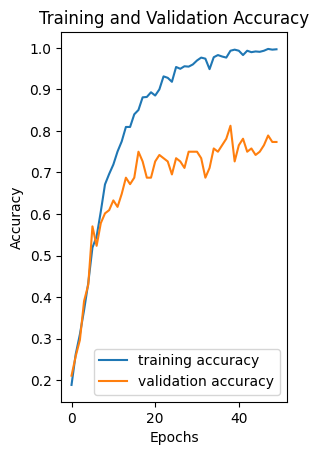

In [28]:
plt.subplot(1, 2, 2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title('Training and Validation Accuracy')
plt.plot(train_accuracy_history, label="training accuracy")
plt.plot(val_accuracy_history, label="validation accuracy")
plt.legend()
plt.show()

# Evaluation

In [29]:
def evaluate(model, dataloader, device):
    model.eval()
    predictions, actuals = [], []
    
    with torch.no_grad():
        for rgb, flow, labels in dataloader:
            rgb, flow = rgb.to(device), flow.to(device)
            outputs = model(rgb, flow)

            test_preds = torch.argmax(outputs, dim=1)  # Convert logits to class indices
            test_labels = torch.argmax(labels, dim=1)  # Convert one-hot labels to class indices

            # Extend the lists
            predictions.extend(test_preds.cpu().numpy())
            actuals.extend(test_labels.cpu().numpy())
    
    accuracy = accuracy_score(actuals, predictions)
    return accuracy, confusion_matrix(actuals, predictions)

In [30]:
# Load the best model
# model.load_state_dict(torch.load('/kaggle/working/best_model.pth', map_location=torch.device('cpu')))
model.load_state_dict(torch.load('/kaggle/working/best_model.pth'))

# Evaluation
accuracy, conf_matrix = evaluate(model, test_loader, device)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.7962382445141066


In [31]:
class_mapping

{'biking': 0,
 'trampoline_jumping': 1,
 'swing': 2,
 'walking': 3,
 'golf_swing': 4,
 'soccer_juggling': 5,
 'tennis_swing': 6,
 'volleyball_spiking': 7,
 'basketball': 8,
 'horse_riding': 9,
 'diving': 10}

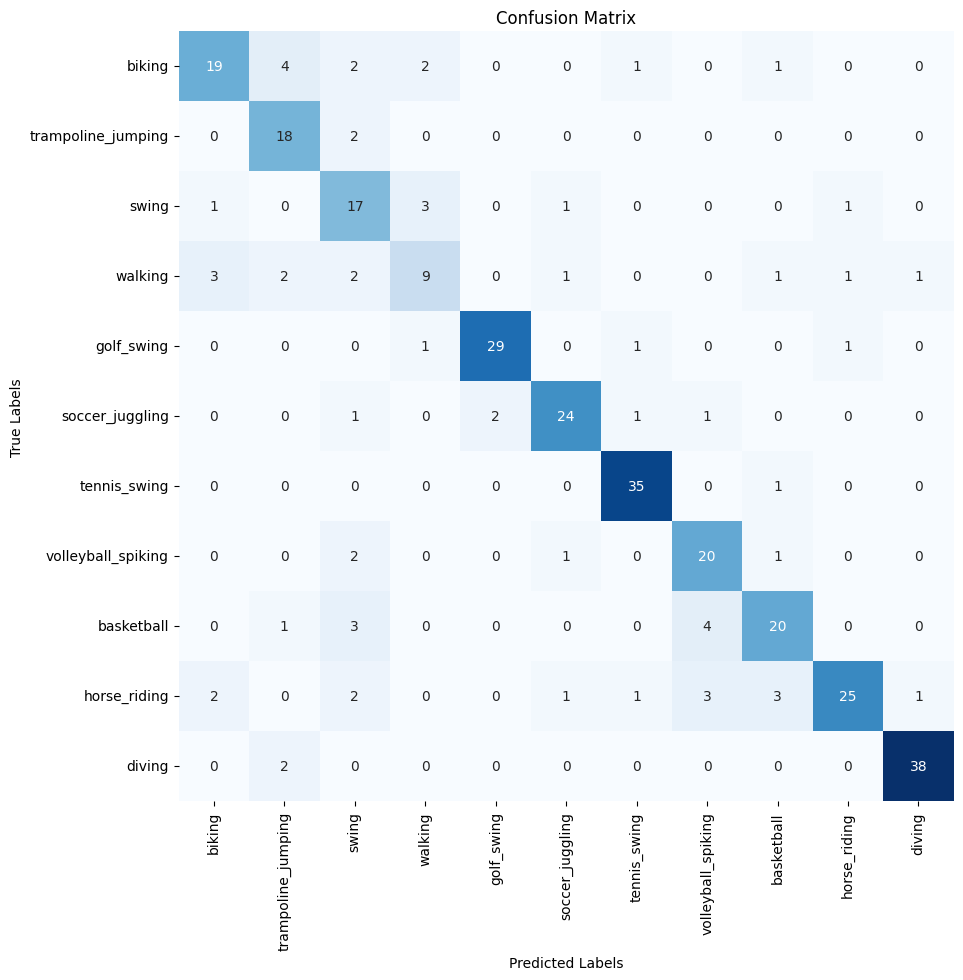

In [32]:
# Create a heatmap of Confusion Matrix
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_mapping.keys(), yticklabels=class_mapping.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Save the heatmap to a file
plt.savefig("/kaggle/working/confusion_matrix.png", dpi=300, bbox_inches='tight')  # Save as PNG with high resolution

plt.show()

In [33]:
import shutil

folder_to_zip = '/kaggle/working/frames'
output_filename = '/kaggle/working/frames'

# Create the zip file
shutil.make_archive(output_filename, 'zip', folder_to_zip)

'/kaggle/working/frames.zip'